In [1]:
import os

import pandas as pd
import numpy as np

from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
samuel_images_validation_dir = 'data/samuel_images_validation'
samuel_images_train_dir = 'data/samuel_images_train'

In [3]:
model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 222, 222, 32)      155       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 109, 109, 64)      2400      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 52, 52, 128)       8896      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 24, 24, 128)       17664     
__________

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        samuel_images_train_dir,
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        samuel_images_validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1294 images belonging to 2 classes.
Found 647 images belonging to 2 classes.


In [7]:
def fit_model():
    return model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=140,
      validation_data=validation_generator,
      validation_steps=50)

In [8]:
%time history = fit_model()

Epoch 1/140
100/100 [==============================] - 51s 513ms/step - loss: 0.6852 - acc: 0.5537 - val_loss: 0.6571 - val_acc: 0.6260
Epoch 2/140
100/100 [==============================] - 46s 460ms/step - loss: 0.6817 - acc: 0.5524 - val_loss: 0.6658 - val_acc: 0.6615
Epoch 3/140
100/100 [==============================] - 47s 468ms/step - loss: 0.6714 - acc: 0.5766 - val_loss: 0.6420 - val_acc: 0.6677
Epoch 4/140
100/100 [==============================] - 47s 467ms/step - loss: 0.6603 - acc: 0.6061 - val_loss: 0.6264 - val_acc: 0.6708
Epoch 5/140
100/100 [==============================] - 48s 477ms/step - loss: 0.6554 - acc: 0.6032 - val_loss: 0.6323 - val_acc: 0.6507
Epoch 6/140
100/100 [==============================] - 47s 466ms/step - loss: 0.6533 - acc: 0.6136 - val_loss: 0.6134 - val_acc: 0.6677
Epoch 7/140
100/100 [==============================] - 46s 459ms/step - loss: 0.6600 - acc: 0.5964 - val_loss: 0.6187 - val_acc: 0.6615
Epoch 8/140
100/100 [===========================

Epoch 61/140
100/100 [==============================] - 46s 462ms/step - loss: 0.5803 - acc: 0.6833 - val_loss: 0.5438 - val_acc: 0.7017
Epoch 62/140
100/100 [==============================] - 48s 475ms/step - loss: 0.5816 - acc: 0.6844 - val_loss: 0.5326 - val_acc: 0.7295
Epoch 63/140
100/100 [==============================] - 46s 459ms/step - loss: 0.5719 - acc: 0.7020 - val_loss: 0.5295 - val_acc: 0.7187
Epoch 64/140
100/100 [==============================] - 49s 487ms/step - loss: 0.5703 - acc: 0.6876 - val_loss: 0.5436 - val_acc: 0.7032
Epoch 65/140
100/100 [==============================] - 46s 459ms/step - loss: 0.5780 - acc: 0.6874 - val_loss: 0.5609 - val_acc: 0.6940
Epoch 66/140
100/100 [==============================] - 45s 455ms/step - loss: 0.5762 - acc: 0.6969 - val_loss: 0.5781 - val_acc: 0.6692
Epoch 67/140
100/100 [==============================] - 46s 462ms/step - loss: 0.5769 - acc: 0.6911 - val_loss: 0.6047 - val_acc: 0.6538
Epoch 68/140
100/100 [===================

### Save Model

In [9]:
model_file = 'data/samuel_images_model_{}.h5'.format(time.time())
model.save(model_file)

print('saved to {}'.format(model_file))

saved to data/samuel_images_model_1533409854.5854547.h5


### Plot The ROC

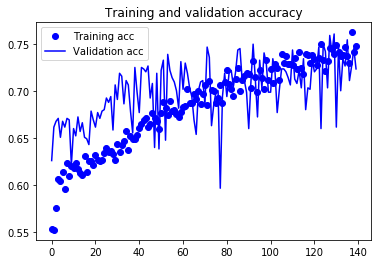

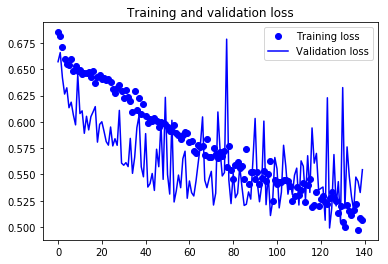

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Validate model

In [11]:
samuel_images_test_dir = 'data/samuel_images_test'

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        samuel_images_test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 302 images belonging to 2 classes.


In [13]:
loss, acc = model.evaluate_generator(test_generator)
print('loss={}, acc={}'.format(loss, acc))

loss=0.761687300655226, acc=0.5761589360552908


### Display predicted items

In [14]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [15]:
predictions = model.predict_generator(test_generator)

In [31]:
test_image_results = pd.DataFrame({
    'prediction': predictions.flatten(),
    'filename': test_generator.filenames
}) \
.sort_values('prediction') \
.head(n=10)

In [32]:
test_image_results

,filename,prediction
255,samuel/00000143.jpg,0.000109
215,samuel/00000072.jpg,0.000134
177,samuel/00000013.jpg,0.000732
223,samuel/00000086.jpg,0.001792
171,samuel/00000003.jpg,0.005380
229,samuel/00000100.jpg,0.007524
287,samuel/1613.jpg,0.008628
65,notSamuel/667.jpg,0.008801
149,notSamuel/889.jpg,0.009906
264,samuel/00000163.jpg,0.010973


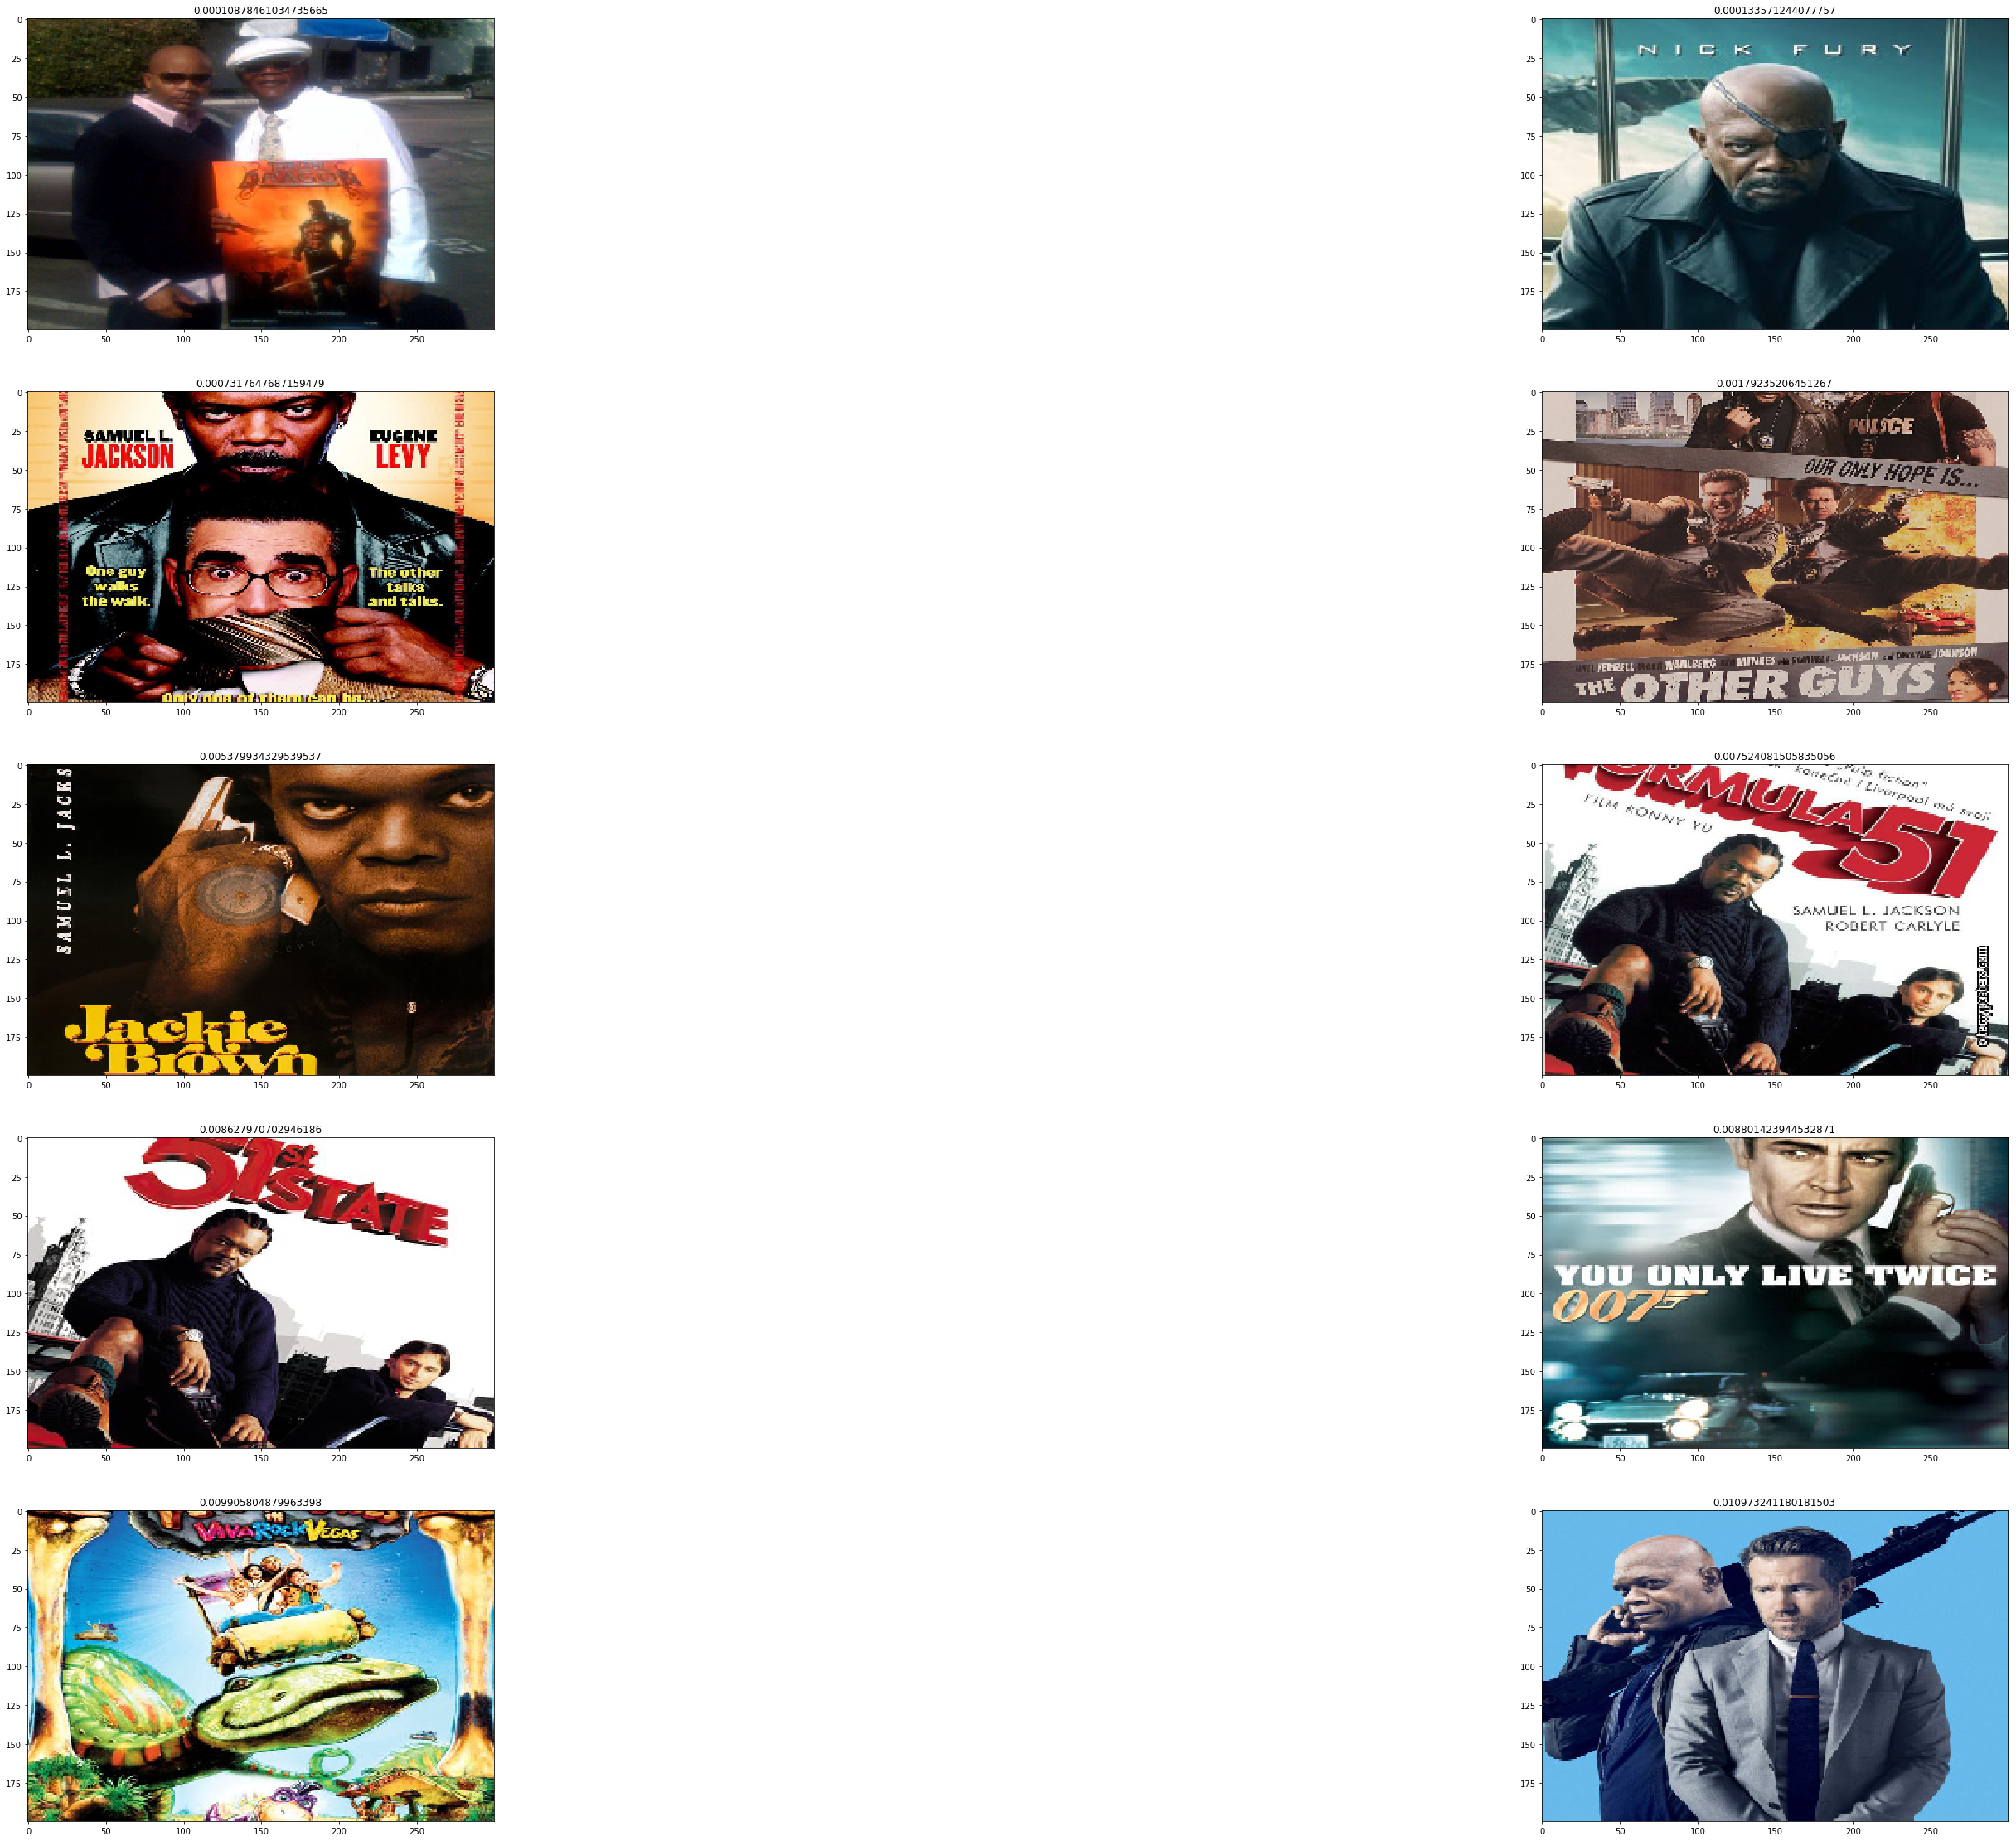

In [22]:
fnames = [os.path.join(samuel_images_test_dir, fname) for fname in test_image_results.filename]

imgs = [image.load_img(fname, target_size=(200,300)) for fname in fnames]
show_images(imgs, 5, test_image_results.prediction)

In [19]:
# Use Grid Search to use all cores https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
